# Dataset

In [ ]:
%%writefile utils/datasets/dataset.py
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as v2
import torch

import warnings
warnings.filterwarnings('ignore')


abc = "0123456789ABEKMHOPCTYX"

class TextRecognitionDataset(Dataset):
    """Class for training image-to-text mapping using CTC-Loss."""

    def __init__(self, phase, config=None, root='./data',  alphabet=abc, transform=None, preprocessing=None):
        """Constructor for class.
        
        Args:
            - phase:         String: 'train' or 'test'
            - root:          Dir with images
            - alphabet:      String of chars required for predicting.
            - transforms:    Transformation for items, should accept and return dict with keys "image", "seq", "seq_len" & "text".
            - preprocessing: Transformation for Complex images with classical cv methods
        """
        super(TextRecognitionDataset, self).__init__()

        self.transform = transform
        self.config=config
        self.phase = phase
        self.root = root
        self.alphabet = alphabet

        self.preprocessing = preprocessing

        self._parse_path()

        if phase=='train':
            assert len(self.config) == len(self.all_images)
            print('Dataset size: ', len(self.config))        
        
    def __getitem__(self, index):
        """Returns dict with keys "image", "seq", "seq_len" & "text".
        Image is a numpy array, float32, [0, 1].
        Seq is list of integers.
        Seq_len is an integer.
        Text is a string.
        """

        image = self.all_images[index]   
        text = self.image2label[image]

        seq = self.text_to_seq(text)
        seq_len = len(seq)


        if self.phase == 'train':
            image_path = os.path.join(self.config[image])                           # train simple phase
        else: 
            image_path = os.path.join(self.image_path, image)               # test phase


        # read images and make one channel (gray)
        image  = cv2.imread(image_path).astype(np.float32) / 255.
        # image = image.convert('L')


        if self.preprocessing:
            image = self.preprocessing(image)


        output = dict(image=image, seq=seq, seq_len=seq_len, text=text)
        if self.transform:
            output = self.transform(output)
        return output
        

    def __len__(self):
        return len(self.image2label)
    

    def text_to_seq(self, text):
        """Encode text to sequence of integers.

        Args:
            - String of text.
        Returns:
            List of integers where each number is index of corresponding characted in alphabet + 1.
        """
        
        seq = [self.alphabet.find(c) + 1 for c in text]
        
        return seq


    def _parse_path(self):

        if self.phase == 'train':

            self.all_images = list(self.config.keys())
            self.image2label = {label: label.split('.')[0].split('_')[-1] for label in self.all_images}

        elif self.phase == 'test':
            self.image_path = os.path.join(self.root, self.phase, 'result')
            self.all_images = sorted(os.listdir(self.image_path), key=lambda x: int(x.split('.')[0]))
            self.image2label = {label: label.split('.')[0] for label in self.all_images}
            
        else:
            raise ValueError('Wrong name for phase: choose "train" or "test"')  



def get_dataconfig(train_ratio, list_examples, path):
    treshold = int(train_ratio * len(list_examples))
    train = list_examples[:treshold]
    val = list_examples[treshold:]

    train_config = {label: os.path.join(path, label) for label in train}
    val_config = {label: os.path.join(path, label) for label in val}

    return train_config, val_config


def get_train_val(ratio, root='data'):
    train_path = os.path.join(root, 'train', 'train')

    complex_path = os.path.join(train_path, 'complex')
    simple_path = os.path.join(train_path, 'simple')


    complex_images = os.listdir(complex_path)
    simple_images = os.listdir(simple_path)


    train_simple, val_simple = get_dataconfig(ratio, simple_images, simple_path)
    train_complex, val_complex = get_dataconfig(ratio, complex_images, complex_path)

    train_config = dict(list(train_simple.items()) + list(train_complex.items()))
    val_config = dict(list(val_simple.items()) + list(val_complex.items()))

    return train_config, val_config



# preprocessing: Transformation for Complex images with classical cv methods
def ada_thr(img):
    """Function for preprocessing images.
    Args:
        - img: numpy array.
    Returns:
        concatenated numpy array of images with different treshold methods
    """
    ada_mean_thr = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
    ada_gaus_thr = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    result = np.concatenate([img[:, :, None], ada_mean_thr[:, :, None], ada_gaus_thr[:, :, None]], axis=2)
    return result


class Resize(object):

    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, item):
        """Apply resizing.
        Args: 
            - item: Dict with keys "image", "seq", "seq_len", "text".
        Returns: 
            Dict with image resized to self.size.
        """
        
        interpolation = cv2.INTER_AREA if self.size[0] < item["image"].shape[1] else cv2.INTER_LINEAR
        item["image"] = cv2.resize(item["image"], self.size, interpolation=interpolation)
        
        return item
    

def collate_fn(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.

    Args:
        - batch: List of dataset __getitem__ return values (dicts).
    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for item in batch:
        images.append(torch.from_numpy(item["image"]).permute(2, 0, 1).float())
        seqs.extend(item["seq"])
        seq_lens.append(item["seq_len"])
        texts.append(item["text"])

    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch



defualt_transform = Resize(size=(320, 64))


def get_dataloaders(BATCH_SIZE=16, train_ratio=0.9, preprcoessing=False, transform=defualt_transform, root='data'):
    if preprcoessing:
        preprocessing_fun = ada_thr
    else:
        preprocessing_fun = None


    train_config, val_config = get_train_val(train_ratio)
    train_set = TextRecognitionDataset('train', config=train_config, preprocessing=preprocessing_fun, transform=transform)
    val_set = TextRecognitionDataset('train', config=val_config, preprocessing=preprocessing_fun, transform=transform)
    test_set = TextRecognitionDataset('test', preprocessing=preprocessing_fun, transform=transform)

    train = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, collate_fn=collate_fn)
    val = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, collate_fn=collate_fn)
    test = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, collate_fn=collate_fn)

    return train, val, test



if __name__ == '__main__':    
    BATCH_SIZE=16
    print(f'{BATCH_SIZE=}')
    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(BATCH_SIZE=BATCH_SIZE) 
    print(len(train_dataloader), len(val_dataloader), len(test_dataloader))
        
    for batch in train_dataloader:
        print('TRAIN')
        print('image', batch['image'].shape)
        print('seq', batch['seq'])
        print('seq_len', batch['seq_len'])
        print('text', batch['text'])
        print()
        break

    for batch in test_dataloader:
        print('TEST')
        print('image',batch['image'].shape)
        print('seq', batch['seq'])
        print('seq_len', batch['seq_len'])
        print('tresh', batch['text'])
        print()
        break


In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
img_path = r'C:\Users\julia\Documents\masters\deep_learning\text_recognition\data\train\train\complex\rus_00002_E031CM777.png'


image  = cv2.imread(img_path).astype(np.float32) / 255.

In [27]:
def ada_thr(img):
    """Function for preprocessing images.
    Args:
        - img: numpy array.
    Returns:
        concatenated numpy array of images with different treshold methods
    """
    ada_mean_thr = cv2.adaptiveThreshold(img, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11, 2)
    ada_gaus_thr = cv2.adaptiveThreshold(img, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11, 2)
    result = np.concatenate([img[:, :, None], ada_mean_thr[:, :, None], ada_gaus_thr[:, :, None]], axis=2)
    return result

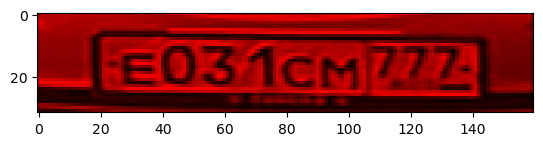

In [28]:
plt.imshow(ada_thr(image[:, :, 0]))


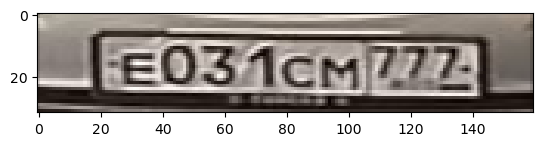

In [20]:
plt.imshow(image)

In [10]:
!python utils/datasets/dataset.py

BATCH_SIZE=16
Dataset size:  22090
['rus_00003_B026CO90.png', 'rus_00004_C421PA35.png', 'rus_00005_B696TT35.png', 'rus_00006_B667AE35.png', 'rus_00009_Y487BY35.png', 'rus_00014_A991CX35.png', 'rus_00016_B038HE35.png', 'rus_00017_P112CK777.png', 'rus_00019_B944CY197.png', 'rus_00020_X009OB750.png', 'rus_00022_X030HO98.png', 'rus_00024_K377BA777.png', 'rus_00025_A628XH35.png', 'rus_00026_E964MT82.png', 'rus_00027_H763XB777.png', 'rus_00028_A518XX35.png', 'rus_00029_P494KE197.png', 'rus_00032_P126XK178.png', 'rus_00034_K974HB97.png', 'rus_00035_A368CM750.png', 'rus_00036_X162AH777.png', 'rus_00037_P494KE197.png', 'rus_00040_C523YB86.png', 'rus_00041_A675YX77.png', 'rus_00044_T301BP750.png', 'rus_00045_H998TO197.png', 'rus_00047_C505XX42.png', 'rus_00048_C843PB96.png', 'rus_00049_P846BK750.png', 'rus_00051_X272AT799.png', 'rus_00053_Y873MA197.png', 'rus_00054_B449KP35.png', 'rus_00055_P090MA35.png', 'rus_00056_T858EP154.png', 'rus_00057_B657YX35.png', 'rus_00059_C431OX35.png', 'rus_00061_H

c:\Users\julia\miniconda3\envs\work\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Не найдена указанная процедура'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\julia\miniconda3\envs\work\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence t

# Model

In [23]:
%%writefile model/model.py
from torch.nn            import Module, Sequential, Conv2d, AvgPool2d, GRU, Linear
from torchvision         import models
import torch

import warnings
warnings.filterwarnings("ignore")

abc = "0123456789ABEKMHOPCTYX"

class FeatureExtractor(Module):
    
    def __init__(self, backbone, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, backbone)(pretrained=True)
        print('load backbone: ', backbone)
        
        self.cnn = Sequential(*list(resnet.children())[:-2])
        
        self.pool = AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        Args:
            - x: Tensor of features (shaped B x C x H x W).
        Returns:
            New tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        # Pool to make height == 1
        features = self.pool(features)
        # Apply projection to increase width
        features = self.apply_projection(features)
        return features
    


class SequencePredictor(Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        Args:
            - batch_size: Int size of batch
        Returns:
            Tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        h = torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)        
        return h
        
    def _reshape_features(self, x):
        """Change dimensions of x to fit RNN expected input.
        Args:
            - x: Tensor x shaped (B x (C=1) x H x W).
        Returns:
            New tensor shaped (W x B x H).
        """
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)        
        return x
    
    def forward(self, x):
        x = self._reshape_features(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x
    


class CRNN(Module):
    
    def __init__(self, backbone='resnet18', alphabet=abc,
                 cnn_input_size=(64, 320), cnn_output_len=20,
                 rnn_hidden_size=128, rnn_num_layers=2, rnn_dropout=0.3, rnn_bidirectional=False):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        self.features_extractor = FeatureExtractor(
            backbone=backbone,
            input_size=cnn_input_size, output_len=cnn_output_len
        )
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size, num_layers=rnn_num_layers,
            num_classes=len(alphabet)+1, dropout=rnn_dropout,
            bidirectional=rnn_bidirectional
        )
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence


if __name__ == '__main__':
    crnn = CRNN()

    x = torch.randn(2, 3, 64, 320)
    y = crnn(x)
    assert y.size() == (20, 2, 23)
    print('Pipeline CRNN is ready!')


Overwriting model/model.py


In [24]:
!python model/model.py

load backbone:  resnet18
Pipeline CRNN is ready!


c:\Users\julia\miniconda3\envs\work\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Не найдена указанная процедура'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Training process

In [22]:
%%writefile utils/decode.py
import numpy as np 


abc = "0123456789ABEKMHOPCTYX"

def pred_to_string(pred, abc=abc):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([abc[c] for c in out])
    return out

def decode(pred, abc=abc):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], abc))
    return outputs

Overwriting utils/prediction/decode.py


In [3]:
%%writefile utils/train_model.py
from utils.decode import decode
from utils.validation import eval_model
import torch
from torch.nn.functional import ctc_loss, log_softmax
from rapidfuzz.distance import Levenshtein

import numpy as np 

from tqdm import tqdm
import time
import wandb
import gc
import os


def training(model, config, train_dataloader, val_dataloader, optimizer, log=True):
    
    start_epoch=0
    if config['checkpoint']:
        model, optimizer,  epoch = load_checkpoint(model, config['save_path'], optimizer)


    best_loss = np.inf
    best_metrics = np.inf
    num_epoch = config['num_epochs']

    for i, epoch in enumerate(range(num_epoch), start_epoch):
        model.train()
        start_time = time.time()

        epoch_losses = []
        epoch_metrics = []

        for j, b in enumerate(tqdm(train_dataloader, total=len(train_dataloader))):
            images = b["image"].to(config['device'])
            seqs_gt = b["seq"]
            seq_lens_gt = b["seq_len"]

            seqs_pred = model(images).cpu()

            seqs_decoded = decode(seqs_pred)
            epoch_metrics.append(
                Levenshtein.distance(seqs_decoded, b["text"]))


            log_probs = log_softmax(seqs_pred, dim=2)
            seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

            loss = ctc_loss(log_probs=log_probs,          # (T, N, C)
                            targets=seqs_gt,              # N, S or sum(target_lengths)
                            input_lengths=seq_lens_pred,  # N
                            target_lengths=seq_lens_gt)   # N

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            # clean tresh
            del b
            gc.collect()
            torch.cuda.empty_cache() 

        epoch_loss = round(np.mean(epoch_losses), 3)
        epoch_metrics  = round(np.mean(epoch_metrics), 3)

        end_time = time.time()
        epoch_time=round(end_time-start_time, 3)
        
        print(f'[{epoch}]/[{num_epoch}] | TRAIN: {epoch_loss=}, {epoch_metrics=}, time: {epoch_time}')
        val_loss, val_metrics = eval_model(model, config, val_dataloader, test=False, log=log)

        
        if log:
            wandb.log({"TRAIN loss": epoch_loss, "TRAIN metrics": epoch_metrics})


        if val_metrics < best_metrics:
            best_metrics = val_metrics
            name = config['name']
            name_checkpoint = f'{name}.pth'
            save_path = os.path.join(os.getcwd(), config['save_path'], name_checkpoint)
            save_checkpoint(model, optimizer, save_path, epoch)




    

def save_checkpoint(model, optimizer, filename, EPOCH):
        with open(filename, "wb") as fp:
            torch.save(model.state_dict(), fp)

            torch.save({
                'epoch': EPOCH,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, filename)
            

def load_checkpoint(model, filename, optimizer=None):
    loaded_checkpoint = {}

    with open(filename, "rb") as fp:
        checkpoint = torch.load(fp, map_location="cpu")
        model.load_state_dict(checkpoint['model_state_dict'])

        if optimizer:
             optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
             
    print('ckeckpoint loaded')
    return model, optimizer,  checkpoint['epoch']

if __name__ == '__main__':    
    print('Everything is ready!')

Overwriting utils/train_model.py


# Evaluaiton and Prediction

In [1]:
%%writefile utils/validation.py
from utils.decode import decode
import torch
from torch.nn.functional import ctc_loss, log_softmax
from rapidfuzz.distance import Levenshtein

import numpy as np 
import pandas as pd

from tqdm import tqdm
import wandb
import gc
import os


def eval_model(model, config, val_dataloader, test=False, log=True):
    model.eval()
    val_losses = []
    epoch_metrics = []
    prediciton = []
    for i, b in enumerate(tqdm(val_dataloader, total=len(val_dataloader))):
        images = b["image"].to(config['device'])
        seqs_gt = b["seq"]
        seq_lens_gt = b["seq_len"]

        with torch.no_grad():
            seqs_pred = model(images).cpu()

        seqs_decoded = decode(seqs_pred)
        epoch_metrics.append(Levenshtein.distance(seqs_decoded, b["text"]))

        if test:
            prediciton.extend(seqs_decoded)
        
        log_probs = log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = ctc_loss(log_probs=log_probs,          # (T, N, C)
                        targets=seqs_gt,              # N, S or sum(target_lengths)
                        input_lengths=seq_lens_pred,  # N
                        target_lengths=seq_lens_gt)   # N

        val_losses.append(loss.item())

        # clean tresh
        del b
        gc.collect()
        torch.cuda.empty_cache()

    val_loss = round(np.mean(val_losses), 3)
    val_metrics = round(np.mean(epoch_metrics), 3)

    print('VALIDATION Loss: ', val_loss, 'metrics: ', val_metrics, '\n')
    if log:
        wandb.log({"VALIDATION loss": val_loss, "VALIDATION metrics": val_metrics}) 


    if test:
        filename=config['name']

        submition = pd.read_csv('data/submission.csv')
        submition['label'] = prediciton
        submition.to_csv(f'results/{filename}.csv', index=False)

    else:
        return val_loss, val_metrics

if __name__ == '__main__':
    print('Everything is ready!')

Overwriting utils/validation.py


# Build Baseline

In [6]:
%%writefile baseline.py
from utils.datasets.dataset import get_dataloaders
from model.model import CRNN
from utils.train_model import training
from utils.validation import eval_model

import torch
import wandb

import warnings
warnings.filterwarnings('ignore')


config = {
    'name'      : 'baseline',


    'num_epochs': 2,
    'batch_size': 64,
    'device'    : 'cuda:0',

    'checkpoint': False,
    'save_path' : 'checkpoints',
    'log'       : True,
}



if __name__ == '__main__':

    if config['log']:
        wandb.login(key="cfedead01b64744b86b1cc0779b5ab7c10fc942f")

        wandb.init(
            project="ML3_HW3",
            name=config['name'],
            reinit=True,
            config=config,
        )

    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(BATCH_SIZE=config['batch_size'], train_ratio=0.9)

    model = CRNN()
    model.to(config['device'])

    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)

    training(model, config, train_dataloader, val_dataloader, optimizer, config['log'])
    eval_model(model, config, test_dataloader, test=True, log=False)
    wandb.finish()

    print('FINISH')

Overwriting baseline.py


In [4]:
!nvidia-smi

Sat Dec  9 21:51:54 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.97                 Driver Version: 531.97       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 L...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P0               13W /  N/A|      0MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!python baseline.py

^C


TRAIN: epoch_loss=2.589, epoch_metrics=64.0, time: 33.406
VALIDATION Loss:  1.655 metrics:  63.866 

TRAIN: epoch_loss=1.04, epoch_metrics=60.869, time: 51.19
VALIDATION Loss:  0.481 metrics:  44.219 

VALIDATION Loss:  11.84 metrics:  63.745 

FINISH


c:\Users\julia\miniconda3\envs\work\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Не найдена указанная процедура'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\julia\miniconda3\envs\work\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence t